# Dataset

In [32]:
import datasets
from datasets import load_dataset

In [33]:
# https://github.com/huggingface/datasets

#
# Download the dataset
#

raw_datasets = load_dataset(
    "wikitext", 
    "wikitext-103-v1"
)

In [34]:
# https://en.wikipedia.org/wiki/Valkyria_Chronicles_III

for i in range(10):
    print(raw_datasets['train'][i])

{'text': ''}
{'text': ' = Valkyria Chronicles III = \n'}
{'text': ''}
{'text': ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n'}
{'text': " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments 

## Tokenize the dataset

In [35]:
from transformers import AutoTokenizer

# Download tokenizer model
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-125m', use_fast=True)

In [36]:
class Wrapper:
    def __init__(self, tok):
        self.tok = tok
        
    def __call__(self, examples):
        return self.tok(examples['text'])


tokenized_datasets = raw_datasets.map(
    Wrapper(tokenizer),
    batched=True,
    num_proc=32,
    remove_columns=raw_datasets["train"].column_names,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

In [37]:
for i in range(10):
    print(tokenized_datasets['train'][i])

{'input_ids': [2], 'attention_mask': [1]}
{'input_ids': [2, 5457, 468, 44068, 6374, 41674, 6395, 5457, 1437, 50118], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [2], 'attention_mask': [1]}
{'input_ids': [2, 2211, 267, 38183, 117, 468, 44068, 6374, 155, 4832, 28696, 6435, 15698, 41674, 36, 2898, 4832, 47416, 23133, 18164, 42393, 21402, 20024, 48018, 50033, 49080, 49587, 49432, 48947, 49017, 246, 2156, 6474, 479, 468, 44068, 6374, 9, 5, 36954, 155, 4839, 2156, 10266, 4997, 7, 25, 468, 44068, 6374, 41674, 6395, 751, 1429, 2156, 16, 10, 15714, 774, 787, 12, 1039, 816, 569, 177, 2226, 30, 43561, 8, 2454, 4, 36753, 13, 5, 15592, 39435, 479, 30939, 11, 644, 1466, 11, 1429, 2156, 24, 16, 5, 371, 177, 11, 5, 468, 44068, 6374, 651, 479, 23564, 154, 5, 276, 24904, 9, 15714, 8, 588, 787, 12, 1039, 86, 23841, 25, 63, 20193, 2156, 5, 527, 1237, 12980, 7, 5, 78, 177, 8, 3905, 5, 22, 8603, 13802, 22, 2156, 10, 14914, 831, 1933, 2754, 5, 1226, 9, 7155, 493, 148, 5, 4665, 5122, 12560

In [7]:
tokenizer.model_max_length

1000000000000000019884624838656

## Group text in block

In [38]:
block_size = 1024

In [39]:


class GroupText:
    def __init__(self, block_size):
        from itertools import chain
        
        self.block_size = block_size
        self.chain = chain
        
    def __call__(self, examples):
        # Concatenate all texts.
        concatenated_examples = {
            k: list(self.chain(*examples[k])) 
                for k in examples.keys()
        }
        
        total_length = len(concatenated_examples[list(examples.keys())[0]])
        
        if total_length >= self.block_size:
            total_length = (total_length // self.block_size) * self.block_size
            
        # Split by chunks of max_len.
        result = {
            k: [t[i : i + self.block_size] 
                for i in range(0, total_length, self.block_size)]
                    for k, t in concatenated_examples.items()
        }
        result["labels"] = result["input_ids"].copy()
        return result


In [40]:
lm_datasets = tokenized_datasets.map(
    GroupText(block_size),
    batched=True,
    num_proc=32,
    load_from_cache_file=True,
    desc=f"Grouping texts in chunks of {block_size}",
)

In [41]:
lm_datasets['train'][0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [42]:
print(' IDS:', lm_datasets['train'][0]['input_ids'][:10])
print(' MASK', lm_datasets['train'][0]['attention_mask'][:10])
print('LABEL', lm_datasets['train'][0]['labels'][:10])

 IDS: [2, 2, 5457, 468, 44068, 6374, 41674, 6395, 5457, 1437]
 MASK [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
LABEL [2, 2, 5457, 468, 44068, 6374, 41674, 6395, 5457, 1437]


In [27]:
from transformers import AutoConfig, AutoModelForCausalLM
    
config = AutoConfig.from_pretrained('facebook/opt-125m')
print(config)
model = AutoModelForCausalLM.from_config(config)

model.resize_token_embeddings(len(tokenizer))

OPTConfig {
  "_name_or_path": "facebook/opt-125m",
  "_remove_final_layer_norm": false,
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "OPTForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "do_layer_norm_before": true,
  "dropout": 0.1,
  "enable_bias": true,
  "eos_token_id": 2,
  "ffn_dim": 3072,
  "hidden_size": 768,
  "init_std": 0.02,
  "layer_norm_elementwise_affine": true,
  "layerdrop": 0.0,
  "max_position_embeddings": 2048,
  "model_type": "opt",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "prefix": "</s>",
  "torch_dtype": "float16",
  "transformers_version": "4.31.0",
  "use_cache": true,
  "vocab_size": 50272,
  "word_embed_proj_dim": 768
}



Embedding(50265, 768)

In [28]:
from transformers import default_data_collator
from torch.utils.data import DataLoader


# DataLoaders creation:
train_dataset = lm_datasets["train"]
eval_dataset = lm_datasets["validation"]

per_gpu_batch_size = 2

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=per_gpu_batch_size,
)

eval_dataloader = DataLoader(
    eval_dataset, 
    collate_fn=default_data_collator, 
    batch_size=per_gpu_batch_size,
)

In [ ]:
for batch in train_dataloader:
    print(batch.keys())
    
    print(batch['input_ids'][:, :10])
    print(batch['attention_mask'][:, :10])
    print(batch['labels'][:, :10])
    break

# Optimizer

WTF is this why do we need to split the parameters here

In [ ]:
no_decay = ["bias", "LayerNorm.weight"]
parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(no_decay_str in n for no_decay_str in no_decay)
        ],
        "weight_decay": 0.0,
    },
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if any(no_decay_str in n for no_decay_str in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [ ]:
from transformers import get_scheduler, SchedulerType
import torch.optim

max_train_steps = 10
gradient_accumulation_steps = 1

optimizer = torch.optim.AdamW(parameters, lr=5e-5)

lr_scheduler = get_scheduler(
    name=SchedulerType.LINEAR,
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)

In [ ]:
from accelerate import Accelerator

# Prepare everything with our `accelerator`.
accelerator = Accelerator(
    mixed_precision='fp16'
)

(
    model,
    optimizer,
    train_dataloader,
    eval_dataloader,
    lr_scheduler,
) = accelerator.prepare(
    model, 
    optimizer, 
    train_dataloader, 
    eval_dataloader, 
    lr_scheduler
)

In [ ]:
batch_count = len(train_dataloader)
max_epoch = 10
total = batch_count * max_epoch

for epoch in range(0, max_epoch):
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        
        outputs = model(**batch)
        
        loss = outputs.loss
        
        loss = loss / gradient_accumulation_steps
        
        accelerator.backward(loss)
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        print(f"\r{(epoch * batch_count + step) * 100/total:.2f}", end='')
        break
    break

In [ ]:
print(loss.item())

In [ ]:
model

In [ ]:
type(model)

# Transformer in a nutshell

## Convert Word to ID

Handled by the tokenizer

In [43]:
sentence = "Hello, how are you"

tokenized = tokenizer(sentence)

print(tokenized)

{'input_ids': [2, 31414, 6, 141, 32, 47], 'attention_mask': [1, 1, 1, 1, 1, 1]}


## Convert Word ID to a vector called Embedding

In [44]:
import torch
import torch.nn as nn

In [45]:
print(len(tokenizer))

50265


In [48]:
word_count = len(tokenizer)
embedding_size = 4

embedding = nn.Embedding(
    word_count,
    embedding_size
)

words = torch.tensor([
    [0, 1, 2, 3],
    [4, 5, 6, 7]
], dtype=torch.long)


result = embedding(words)

print(words.shape)
print(result.shape)

result

torch.Size([2, 4])
torch.Size([2, 4, 4])


tensor([[[-0.1390, -0.9837,  0.3531, -0.3547],
         [-0.8929,  0.4041, -0.0699, -1.1943],
         [-0.2368,  0.6996,  1.0251,  0.0677],
         [ 1.5096, -2.6156,  1.7917,  1.2650]],

        [[-0.1082,  1.4285,  0.8797,  0.9152],
         [ 0.0837, -0.3266, -0.7952,  0.6647],
         [ 0.0863, -0.9669, -0.3809, -0.0290],
         [ 0.3739, -0.8265,  0.1591,  0.3284]]], grad_fn=<EmbeddingBackward0>)

## Summary

In [17]:
sentence = "Hello, how are you"

tokenized = tokenizer(sentence)

batch = torch.tensor([
    tokenized['input_ids'],
    tokenized['input_ids']
], dtype=torch.long)

result = embedding(batch)

print(result.shape)
print(result)

torch.Size([2, 6, 4])
tensor([[[ 0.4105, -0.4263, -0.3554, -0.0040],
         [-1.1915, -0.3207, -0.0155,  0.1284],
         [ 1.1196, -0.5289, -1.0816, -0.0611],
         [-2.0500, -2.6651, -0.4958, -0.5997],
         [ 1.0940,  0.4501, -0.8789, -0.7428],
         [ 0.1306,  1.9094, -0.2398,  0.1954]],

        [[ 0.4105, -0.4263, -0.3554, -0.0040],
         [-1.1915, -0.3207, -0.0155,  0.1284],
         [ 1.1196, -0.5289, -1.0816, -0.0611],
         [-2.0500, -2.6651, -0.4958, -0.5997],
         [ 1.0940,  0.4501, -0.8789, -0.7428],
         [ 0.1306,  1.9094, -0.2398,  0.1954]]], grad_fn=<EmbeddingBackward0>)


#  Attention Layer

In [21]:
# feed_forward(x) = Linear(Silu(Linear(x)) * Linear(x))

# h = x + attention(norm(x), start_pos, freqs_cis, mask)
# out = h + feed_forward(ffn_norm(h))


In [19]:
def positional_encoding(*args):
    return args

def apply_attention_mask(x):
    return x

In [49]:
import torch.nn.functional as F
from math import sqrt

n = embedding_size
x = result

# Single attention

q = nn.Linear(embedding_size, n)
k = nn.Linear(embedding_size, n)
v = nn.Linear(embedding_size, n)
o = nn.Linear(embedding_size, n)

xq = q(x)
xk = k(x)
xv = v(x)

xq, xk = positional_encoding(xq, xk)

out = xq @ xk.transpose(1, 2) / sqrt(256)

out = apply_attention_mask(out) #...

attention_weight = F.softmax(out, dim=-1) 

# Input Selector, if attention_weight == Identity then everything would be equally selected
out = o(attention_weight @ xv)

# feed forward
w1 = nn.Linear(n, n * 2)
w2 = nn.Linear(n * 2, n)
w3 = nn.Linear(n, n * 2)

out = w2(F.silu(w1(out)) * w3(out))

# go to next attention head
print(out)

tensor([[[-0.0075, -0.2360,  0.2781,  0.2571],
         [-0.0074, -0.2360,  0.2781,  0.2571],
         [-0.0043, -0.2373,  0.2784,  0.2577],
         [-0.0055, -0.2369,  0.2784,  0.2574]],

        [[-0.0160, -0.2219,  0.2631,  0.2585],
         [-0.0159, -0.2213,  0.2622,  0.2584],
         [-0.0159, -0.2214,  0.2624,  0.2584],
         [-0.0160, -0.2216,  0.2627,  0.2585]]], grad_fn=<ViewBackward0>)


In [22]:
tokenized

{'input_ids': [2, 31414, 6, 141, 32, 47], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [31]:
next(iter(train_dataloader))

{'input_ids': tensor([[   10,    22, 11346,  ...,     9,  4224,  5648],
         [ 1824,    11,     5,  ...,  1813,   226,  4970]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'labels': tensor([[   10,    22, 11346,  ...,     9,  4224,  5648],
         [ 1824,    11,     5,  ...,  1813,   226,  4970]])}

In [50]:

x = f(x)




NameError: name 'f' is not defined

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

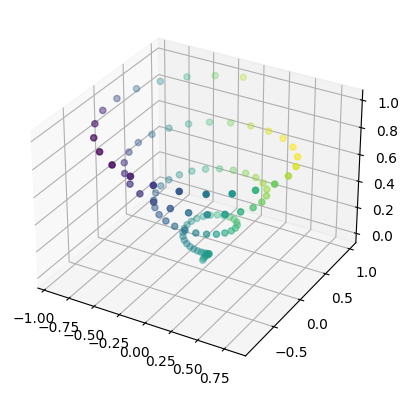

In [52]:
ax = plt.axes(projection ='3d')
 
# defining axes
z = np.linspace(0, 1, 100)
x = z * np.sin(25 * z)
y = z * np.cos(25 * z)
c = x + y

ax.scatter(x, y, z, c = c)

In [53]:
import numpy as np
from mayavi import mlab

# Generate random data points
np.random.seed(42)
num_points = 100
x = np.random.rand(num_points)
y = np.random.rand(num_points)
z = np.random.rand(num_points)

# Create a 3D scatter plot
fig = mlab.figure(figure='3D Scatter Plot', bgcolor=(1, 1, 1), size=(800, 600))
points = mlab.points3d(x, y, z, scale_factor=0.1, color=(0, 0, 1))

# Add legends for each point
legend = mlab.scalarbar(points, title='Point Legends')
legend.scalarbar_representation.position = (0.85, 0.1)
legend.scalarbar_representation.position2 = (0.1, 0.8)

# Rotate the visualization
mlab.view(azimuth=45, elevation=45, distance=4)

# Display the plot
mlab.show()

AttributeError: 'TrivialProducer' object has no attribute 'output'